In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random

import torch
from torchvision.models import resnet18, resnet50, ResNet18_Weights, ResNet50_Weights
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision import transforms
from torchvision.datasets import ImageFolder

In [2]:
seed=260981
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.autograd.set_detect_anomaly(True)

# Data

In [3]:
def get_normalize():
    return transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

def get_transform(input_size=224):
    return transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.ToTensor(),
        get_normalize(),
    ])

def get_augment_transform(scheme_name='default', input_size=224):
    schemes = {}
    schemes['default'] = transforms.Compose([
        transforms.RandomResizedCrop(input_size, scale=(0.7, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(0.3, 0.3, 0.3, 0.3),
        transforms.RandomGrayscale(),
        transforms.ToTensor(),
        get_normalize(),
    ])
    schemes['jigen'] = transforms.Compose([
        transforms.RandomResizedCrop(input_size, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(0.4, 0.4, 0.4, 0.4),
        transforms.RandomGrayscale(),
        transforms.ToTensor(),
        get_normalize(),
    ])
    if scheme_name not in schemes:
        raise KeyError(f'no such data augmentation scheme: {scheme_name}')
    return schemes[scheme_name]

In [4]:
class MultipleDomainDataset:
    N_STEPS = 5001           # Default, subclasses may override
    CHECKPOINT_FREQ = 100    # Default, subclasses may override
    N_WORKERS = 8            # Default, subclasses may override
    ENVIRONMENTS = None      # Subclasses should override
    INPUT_SHAPE = None       # Subclasses should override

    def __getitem__(self, index):
        return self.datasets[index]

    def __len__(self):
        return len(self.datasets)

In [5]:
class MultipleEnvironmentImageFolder(MultipleDomainDataset):
    def __init__(self, root, test_envs, augment, hparams):
        super().__init__()
        environments = [f.name for f in os.scandir(root) if f.is_dir()]
        environments = sorted(environments)

        transform = get_transform()
        augment_scheme = hparams.get('data_augmentation_scheme', 'default')
        augment_transform = get_augment_transform(augment_scheme)

        self.datasets = []
        for i, environment in enumerate(environments):

            if augment and (i not in test_envs):
                env_transform = augment_transform
            else:
                env_transform = transform

            path = os.path.join(root, environment)
            env_dataset = ImageFolder(path, transform=env_transform)

            self.datasets.append(env_dataset)

        self.input_shape = (3, 224, 224,)
        self.num_classes = len(self.datasets[-1].classes)
        self.classes = self.datasets[-1].classes

In [6]:
class OfficeHome(MultipleEnvironmentImageFolder):
    CHECKPOINT_FREQ = 300
    ENVIRONMENTS = ["A", "C", "P", "R"]
    def __init__(self, root, test_envs, hparams):
        self.dir = os.path.join(root, "office_home/")
        super().__init__(self.dir, test_envs, hparams['data_augmentation'], hparams)

In [7]:
oh_ds = OfficeHome('/srv/anisio/does_kd/data', [2], {'data_augmentation':False})

In [8]:
class _SplitDataset(torch.utils.data.Dataset):
    """Used by split_dataset"""
    def __init__(self, underlying_dataset, keys):
        super(_SplitDataset, self).__init__()
        self.underlying_dataset = underlying_dataset
        self.keys = keys
    def __getitem__(self, key):
        return self.underlying_dataset[self.keys[key]]
    def __len__(self):
        return len(self.keys)

def split_dataset(dataset, n, seed=0):
    """
    Return a pair of datasets corresponding to a random split of the given
    dataset, with n datapoints in the first dataset and the rest in the last,
    using the given random seed
    """
    assert(n <= len(dataset))
    keys = list(range(len(dataset)))
    np.random.RandomState(seed).shuffle(keys)
    keys_1 = keys[:n]
    keys_2 = keys[n:]
    return _SplitDataset(dataset, keys_1), _SplitDataset(dataset, keys_2)

In [9]:
def get_loaders(ds, holdout_fraction, bs, test_envs):
    in_splits = []
    out_splits = []

    for env_i, ds_env in enumerate(ds):
        out, in_ = split_dataset(ds_env,
                                 int(len(ds_env)*holdout_fraction),
                                 env_i)
        
        in_splits.append((in_, None))
        out_splits.append((out, None))

    print('in_splits', len(in_splits), 'out_splits', len(out_splits))
    train_loaders = [DataLoader(env, batch_size=bs) for i, (env, _) in enumerate(in_splits) if i not in test_envs]
    eval_loaders = [DataLoader(env, batch_size=bs) for env, _ in (in_splits + out_splits)]
    return train_loaders, eval_loaders

In [10]:
train_loaders, eval_loaders = get_loaders(oh_ds, 0.2, 4, [2])
print('len train_loaders', len(train_loaders), 'len eval_loaders', len(eval_loaders))

in_splits 4 out_splits 4
len train_loaders 3 len eval_loaders 8


In [11]:
from torchvision.utils import make_grid

def show_batch(dl, y, classes, preds=None):
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    fig, ax = plt.subplots(nrows=1, ncols=4)

    for img_id in range(dl.shape[0]):
        ax[img_id].set_xticks([]); ax[img_id].set_yticks([])
        x = dl[img_id, :] * std[:, None, None] + mean[:, None, None]
        ax[img_id].imshow(x.numpy().transpose(1, 2, 0))
        if preds != None:
            title = 'T: %s\nP: %s' % (classes[y[img_id].item()], classes[preds[img_id]])
            ax[img_id].set(title=title)
        else:
            ax[img_id].set(title=classes[y[img_id].item()])

In [12]:
classes = oh_ds.classes

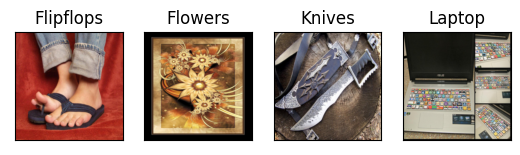

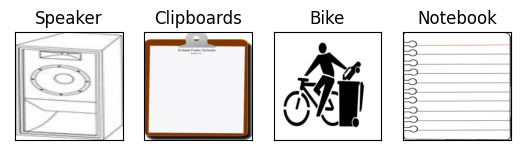

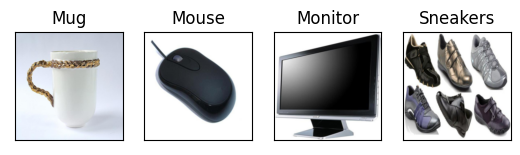

In [13]:
train_minibatches_iterator = zip(*train_loaders)
for i, (x, y) in enumerate(next(train_minibatches_iterator)):
    show_batch(x, y, classes)

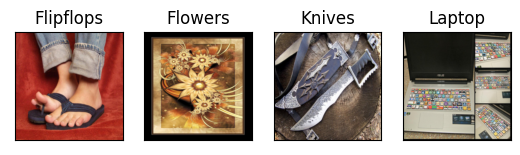

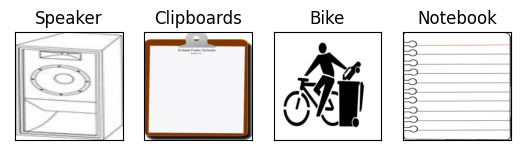

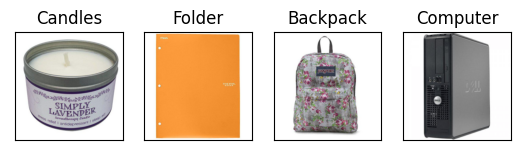

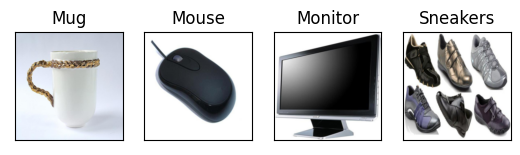

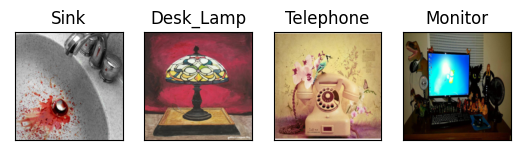

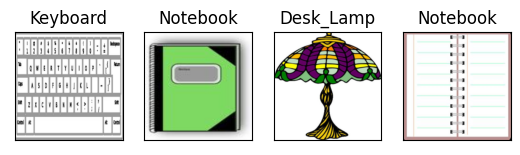

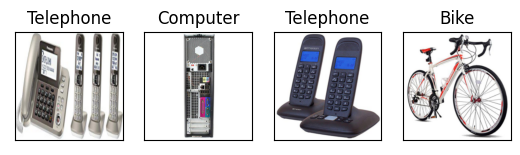

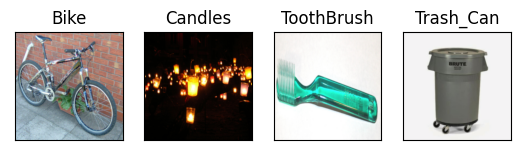

In [14]:
eval_minibatches_iterator = zip(*eval_loaders)
for i, (x, y) in enumerate(next(eval_minibatches_iterator)):
    show_batch(x, y, classes)

# Model

In [15]:
class Identity(torch.nn.Module):
    """An identity layer"""
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

In [16]:
featurizer = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
n_outputs = featurizer.fc.in_features
del featurizer.fc
featurizer.fc = Identity()
classifier = torch.nn.Linear(n_outputs, oh_ds.num_classes)
network = torch.nn.Sequential(featurizer, classifier)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


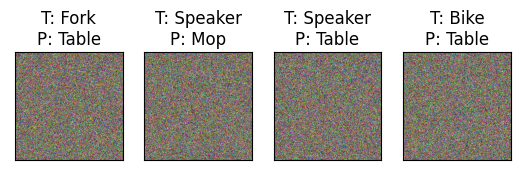

In [17]:
with torch.no_grad():
    imgs = torch.randn(4, 3, 224, 224)
    targets = torch.randint(65, [4])
    preds = network(imgs)
    preds_classes_ids = torch.topk(preds, k=1).indices
    show_batch(imgs, targets, classes, preds_classes_ids)

# Optimization

In [18]:
def train_loop(data_loader, model, loss_fn, optimizer):
    # size = len()
    
    for i, (X, y) in enumerate(next(train_minibatches_iterator)):
        pred = model(X)
        loss = loss_fn(pred, y)

        #Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            loss, current = loss.item(), (i + 1) * len(X)
            print(f'loss: {loss:>7f} [{current:>5d}]')

In [25]:
def test_loop(dataloader, model, loss_fn):
    # size = len(dataloader.dataset)
    # num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for i, (X, y) in enumerate(next(dataloader)):
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    # test_loss /= num_batches
    # correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


In [26]:
n_steps = 5
batch_size = 4
lr = 1e-3

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(network.parameters(), lr=lr)

In [27]:
# train_minibatches_iterator = zip(*train_loaders)
# eval_minibatches_iterator = zip(*eval_loaders)

for t in range(n_steps):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_minibatches_iterator, network, loss_fn, optimizer)
    test_loop(eval_minibatches_iterator, network, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 4.034523 [    4]
Test Error: 
 Accuracy: 0.0%, Avg loss: 33.908815 

Epoch 2
-------------------------------
loss: 4.406787 [    4]
Test Error: 
 Accuracy: 200.0%, Avg loss: 33.241227 

Epoch 3
-------------------------------
loss: 3.993523 [    4]
Test Error: 
 Accuracy: 400.0%, Avg loss: 33.658019 

Epoch 4
-------------------------------
loss: 4.820163 [    4]
Test Error: 
 Accuracy: 0.0%, Avg loss: 32.977746 

Epoch 5
-------------------------------
loss: 3.970465 [    4]
Test Error: 
 Accuracy: 100.0%, Avg loss: 34.520858 

Done!
